In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

from sklearn.datasets import make_moons
data = make_moons(10000, noise=0.05)[0]

epochs = 700
num_of_hidden_layers = 3  #number of layers in each cell
hidden_layers_size = 30 #number of nodes in each layer
num_of_cells = 6 #number of cells in the flow - number of affine transformations
learning_rate = 1e-2
num_of_complete_batches = 10

num_of_features = int(data.shape[1])
len_up   = int(np.floor(num_of_features / 2)) #size of upper part of sample
len_down = int(np.ceil(num_of_features / 2)) #size of down part of sample
#the ceil and floor are incase there is an odd number of features.

In [2]:
def glorot_init(shape):
    return tf.Variable(tf.cast(tf.random.normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.), seed=0), dtype=tf.float64))

#creating dictionaries for weights and biases
weights = dict()
biases = dict()


for i in range(num_of_cells):
    weights['s_up' + str(i) + str(0)] = glorot_init([len_up, hidden_layers_size])
    biases['s_up' + str(i) + str(0)] = glorot_init([hidden_layers_size])
    weights['s_down' + str(i) + str(0)] = glorot_init([len_down, hidden_layers_size])
    biases['s_down' + str(i) + str(0)] = glorot_init([hidden_layers_size])
    weights['t_up' + str(i) + str(0)] = glorot_init([len_up, hidden_layers_size])
    biases['t_up' + str(i) + str(0)] = glorot_init([hidden_layers_size])
    weights['t_down' + str(i) + str(0)] = glorot_init([len_down, hidden_layers_size])
    biases['t_down' + str(i) + str(0)] = glorot_init([hidden_layers_size])

    j=0
    for j in range(1, num_of_hidden_layers):
        weights['s_up' + str(i) + str(j)] = glorot_init([hidden_layers_size, hidden_layers_size])
        biases['s_up' + str(i) + str(j)] = glorot_init([hidden_layers_size])
        weights['s_down' + str(i) + str(j)] = glorot_init([hidden_layers_size, hidden_layers_size])
        biases['s_down' + str(i) + str(j)] = glorot_init([hidden_layers_size])

        weights['t_up' + str(i) + str(j)] = glorot_init([hidden_layers_size, hidden_layers_size])
        biases['t_up' + str(i) + str(j)] = glorot_init([hidden_layers_size])
        weights['t_down' + str(i) + str(j)] = glorot_init([hidden_layers_size, hidden_layers_size])
        biases['t_down' + str(i) + str(j)] = glorot_init([hidden_layers_size])

    # this part is necessary when the number of features is odd so that the ceil and floor methods won't mix up.
    # if the number of features is even, then it would have been enough to change line 41 into:
    # for j in range(num_of_hidden_layers): - and erase the next part.
    # if num_of_hidden_layers == 1:
    #     j = 1
    # else:
    j = j + 1
    weights['s_up' + str(i) + str(j)] = glorot_init([hidden_layers_size, len_down])
    biases['s_up' + str(i) + str(j)] = glorot_init([len_down])
    weights['s_down' + str(i) + str(j)] = glorot_init([hidden_layers_size,len_up])
    biases['s_down' + str(i) + str(j)] = glorot_init([len_up])

    weights['t_up' + str(i) + str(j)] = glorot_init([hidden_layers_size, len_down])
    biases['t_up' + str(i) + str(j)] = glorot_init([len_down])
    weights['t_down' + str(i) + str(j)] = glorot_init([hidden_layers_size, len_up])
    biases['t_down' + str(i) + str(j)] = glorot_init([len_up])

In [4]:
dist = tfp.distributions.MultivariateNormalDiag(loc=[0.0] * num_of_features, scale_diag=[1.0] * num_of_features)

def printer(loss, epoch):
    print('epoch: ' + str(epoch.numpy()) + '  loss: ' + str(np.round(loss.numpy(), 6)))
    return loss

def NN(batch, key, num_of_hidden_layers, weights, biases):
    for k in range(num_of_hidden_layers+1):
        if k==num_of_hidden_layers:
            batch = tf.matmul(batch, weights[key + str(k)]) + biases[key + str(k)]
        else:
           batch = tf.nn.sigmoid(tf.matmul(batch, weights[key + str(k)]) + biases[key + str(k)])
    return batch
NN_func = tf.function(NN)


def forward_pass(batch_x, num_of_features, num_of_cells, weights, biases):
    sum_log_s = 0
    #dividing the input into 2 equal parts (if the input size is odd, than the lower part is larger by 1).
    batch_1 = batch_x[:, 0:int(np.floor(num_of_features / 2))]
    batch_2 = batch_x[:, int(np.floor(num_of_features / 2)):]
    #computing the s & t that each cell outputs for the upper and lower part
    for j in range(num_of_cells):
        #using the upper input to compute s_down & t_down
        log_s_down = tf.tanh(NN(batch_1, 's_up' + str(j), num_of_hidden_layers, weights, biases))#/self.num_of_features
        t_down = tf.tanh(NN_func(batch_1, 't_up' + str(j), num_of_hidden_layers, weights, biases))
        y_2 = tf.multiply(batch_2, tf.exp(log_s_down)) + t_down
        #using the output of the above to comupte s_up & t_up - that way we keep the determinant of the Jacobian simple
        #and still "mix" the features in every iteration
        log_s_up = tf.tanh(NN(y_2, 's_down' + str(j), num_of_hidden_layers, weights, biases))#/self.num_of_features
        t_up = tf.tanh(NN_func(y_2, 't_down' + str(j), num_of_hidden_layers, weights, biases))
        y_1 = tf.multiply(batch_1, tf.exp(log_s_up)) + t_up

        batch_1 = y_1
        batch_2 = y_2

        sum_log_s = sum_log_s + tf.reduce_sum(log_s_down, 1) + tf.reduce_sum(log_s_up, 1)


    batch_x = tf.concat([y_1, y_2], 1)
    return batch_x, sum_log_s
forward_pass_func = tf.function(forward_pass)


def optimize(batch_x, weights, biases ,optimizer, num_of_features, num_of_cells):
    with tf.GradientTape() as g:
        curr_y, sum_log_s = forward_pass_func(batch_x, num_of_features, num_of_cells, weights, biases)
        #the loss is log of the likelihood in the latent space. (including the determinant of the jacobian).
        loss = -tf.reduce_mean(tf.cast(dist.log_prob(tf.cast(curr_y, tf.float32)), tf.float64) + sum_log_s, 0)
    trainable_variables = [[r for r in weights.values()] + [r for r in biases.values()]][0]
    gradients = g.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    return loss, curr_y
optimize_func = tf.function(optimize)


def generate(batch_x, num_of_features, num_of_cells, weights, biases):
    sum_log_s = 0
    # dividing the input into 2 equal parts (if the input size is odd, than the lower part is larger by 1).
    batch_1 = batch_x[:, 0:int(np.floor(num_of_features / 2))]
    batch_2 = batch_x[:, int(np.floor(num_of_features / 2)):]
    # computing the s & t that each cell outputs for the upper and lower part
    for j in range(num_of_cells - 1, -1, -1):
        # using the output of the above to comupte s_up & t_up - that way we keep the determinant of the Jacobian simple
        # and still "mix" the features in every iteration
        # log_s_up = (1-tf.nn.relu(self.NN_func(y_2, 's_down' + str(j))))/self.num_of_features
        log_s_up = tf.tanh(NN(batch_2, 's_down' + str(j), num_of_hidden_layers, weights, biases))  # /self.num_of_features
        t_up = tf.tanh(NN(batch_2, 't_down' + str(j), num_of_hidden_layers, weights, biases))
        y_1 = tf.multiply((batch_1 - t_up), 1 / tf.exp(log_s_up))
        # using the upper input to compute s_down & t_down
        # log_s_down = (1-tf.nn.relu(self.NN_func(batch_1, 's_up' + str(j))))/self.num_of_features
        log_s_down = tf.tanh(NN(y_1, 's_up' + str(j), num_of_hidden_layers, weights, biases))  # /self.num_of_features
        t_down = tf.tanh(NN(y_1, 't_up' + str(j), num_of_hidden_layers, weights, biases))
        y_2 = tf.multiply((batch_2 - t_down), 1 / tf.exp(log_s_down))

        batch_1 = y_1
        batch_2 = y_2

        sum_log_s = sum_log_s + tf.reduce_sum(log_s_down, 1) + tf.reduce_sum(log_s_up, 1)

    batch_x = tf.concat([y_1, y_2], 1)
    return batch_x

In [5]:
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

#calculating batch size
batch_size = int(len(data) / num_of_complete_batches)
residual = len(data) % batch_size


In [6]:
for epoch in range(epochs):
    extra = 0
    for batch in range(num_of_complete_batches):
        if batch == num_of_complete_batches - 1:
            extra = int(residual)
        batch_x = data[batch * batch_size:((batch + 1) * batch_size) + extra]
        ll, emb = optimize_func(batch_x, weights, biases ,optimizer, num_of_features, num_of_cells)
    # # printing the loss of the last batch every 10 epoches
    if epoch % 10 == 0:
        tf.py_function(func=printer, inp=[ll, epoch], Tout=tf.float64)

epoch: 0  loss: 2.757726
epoch: 10  loss: 1.582998
epoch: 20  loss: 1.523534
epoch: 30  loss: 1.303073
epoch: 40  loss: 1.244585
epoch: 50  loss: 1.106306
epoch: 60  loss: 1.200125
epoch: 70  loss: 1.023894
epoch: 80  loss: 0.914052
epoch: 90  loss: 0.735466
epoch: 100  loss: 0.618475
epoch: 110  loss: 0.574734
epoch: 120  loss: 0.479987
epoch: 130  loss: 0.443115
epoch: 140  loss: 0.518821
epoch: 150  loss: 0.475548
epoch: 160  loss: 0.385552
epoch: 170  loss: 0.375974
epoch: 180  loss: 0.37115
epoch: 190  loss: 0.37082
epoch: 200  loss: 0.372018
epoch: 210  loss: 0.372014
epoch: 220  loss: 0.368639
epoch: 230  loss: 0.380525
epoch: 240  loss: 0.379071
epoch: 250  loss: 0.370451
epoch: 260  loss: 0.371403
epoch: 270  loss: 0.368506
epoch: 280  loss: 0.364622
epoch: 290  loss: 0.356711
epoch: 300  loss: 0.398928
epoch: 310  loss: 0.341161
epoch: 320  loss: 0.390226
epoch: 330  loss: 0.376336
epoch: 340  loss: 0.353097
epoch: 350  loss: 0.366659
epoch: 360  loss: 0.360262
epoch: 370  lo

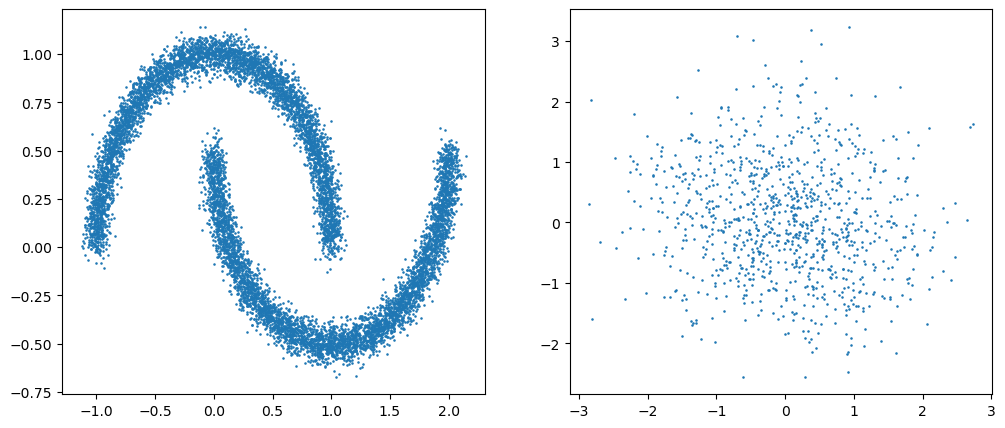

In [13]:
import matplotlib.pyplot as plt
plt.subplot(1, 2, 1)
plt.scatter(data[:, 0], data[:, 1], s=0.7)
plt.subplot(1, 2, 2)
plt.scatter(emb.numpy()[:, 0], emb.numpy()[:, 1], s=0.7)
plt.rcParams["figure.figsize"] =(20,5)
plt.show()

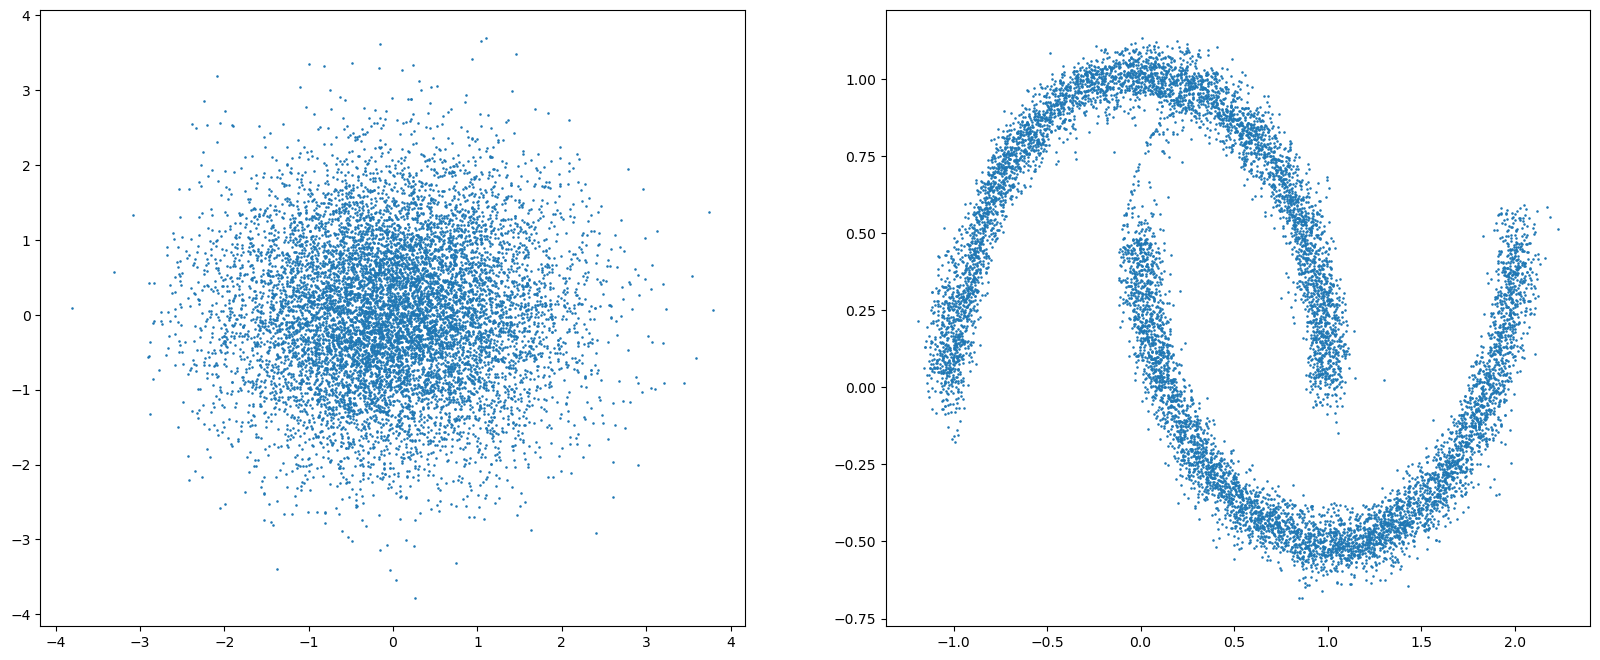

In [16]:
samples = dist.sample(10000)
gen = generate(tf.cast(samples, tf.float64), num_of_features, num_of_cells, weights, biases)
plt.subplot(1, 2, 1)
plt.scatter(samples.numpy()[:, 0], samples.numpy()[:, 1], s=0.7)
plt.subplot(1, 2, 2)
plt.scatter(gen.numpy()[:, 0], gen.numpy()[:, 1], s=0.7)
plt.rcParams["figure.figsize"] =(20,15)
plt.show()